In [1]:
import pandas as pd
import numpy as np
from cobra.io import read_sbml_model  #Loads function to load in json file. The json file (iMM904.json) is in the same folder as this notebook. 
from cobra.util.array import create_stoichiometric_matrix
import re
import matplotlib.pyplot as plt
import os
os.chdir('../..')

In [22]:
#read in yeast8
fba_model=read_sbml_model('../kieran_collab_code/GEM_models/Yeast8/Yeast8.xml')

In [23]:
#get stoichiometry matrix
S=create_stoichiometric_matrix(fba_model,array_type='DataFrame')

In [24]:
print('There are %d metabolites and %d reactions in Yeast 8.' % S.shape)
print('The rows of S are metbolites and the columns are reactions.')
display(S)

There are 2742 metabolites and 4058 reactions in Yeast 8.
The rows of S are metbolites and the columns are reactions.


,r_0001,r_0002,r_0003,r_0004,r_0005,r_0006,r_0007,r_0012,r_0013,r_0014,...,r_4689,r_4690,r_4691,r_4692,r_4693,r_4694,r_4695,r_4697,r_4698,r_4699
s_0001[ce],0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_0002[c],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_0003[e],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_0004[ce],0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_0006[m],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_4257[e],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
s_4258[c],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0
s_4259[e],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
s_4261[c],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0


In [25]:
#extract what letters are used in gene names. This will be useful for filtering out the genes from gene reaction rules (GRRs)/gene protein reactions (GPRs)
genes_letters=''
for gene in fba_model.genes:
    genes_letters+=gene.id
    
print('The letters present in gene ids are:', np.sort(list(set(genes_letters)))) #letters in the gene ids. It is -, 0-9, and A-Z. 

print('There are %d genes.' % len(fba_model.genes))

The letters present in gene ids are: ['-' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G'
 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'W' 'Y']
There are 1150 genes.


In [26]:
#make a dictionary showing which genes control what reactions. This will be used to get a percentage of 
reaction_gene_dict={}
for react in fba_model.reactions:
    grr=react.gene_reaction_rule
    grr_set=list(set(re.findall(r'[\-A-Z\d]+',grr))) #regex to filter genes. All genes use -, capital letters and all digits
    reaction_gene_dict[react.id]=grr_set

In [27]:
#this code will start with biomass and record the upstream metabolites, reactions, and genes. 
current_metabs=['s_0450[c]'] 
metab_dict={}
react_dict={}
metab_set=[]
react_set=[]
gene_set=[]
count_dict={'metab':[],'react':[],'gene':[]}
n_jumps=12
for i in range(n_jumps):
    metab_dict[i]=current_metabs
    metab_set=np.append(metab_set,metab_dict[i])
    react_dict[i]=[]
    for j,metab in enumerate(current_metabs): 
        reactions=S.loc[metab][S.loc[metab]!=0]
        reactions=reactions[reactions>0] #only keep the reactions with positive coeffs so we go upstream in the reactions
        react_dict[i]=list(np.append(react_dict[i],reactions.index))
        for k, react_index in enumerate(reactions.index):
            reactants=S[react_index][S[react_index]!=0]
            reactants=reactants[reactants<0] #the negative coefficients give the reactants in the reaction
            current_metabs=list(reactants.index)
    react_set=np.append(react_set,react_dict[i])
    
    metab_set=list(set(metab_set))
    count_dict['metab']=np.append(count_dict['metab'],len(metab_set))
    react_set=list(set(react_set))
    count_dict['react']=np.append(count_dict['react'],len(react_set))
    
    for react in react_set: 
        gene_set=list(set(np.append(gene_set,reaction_gene_dict[react])))
    count_dict['gene']=np.append(count_dict['gene'],len(gene_set))
    
    #print(len(metab_set),len(react_set))

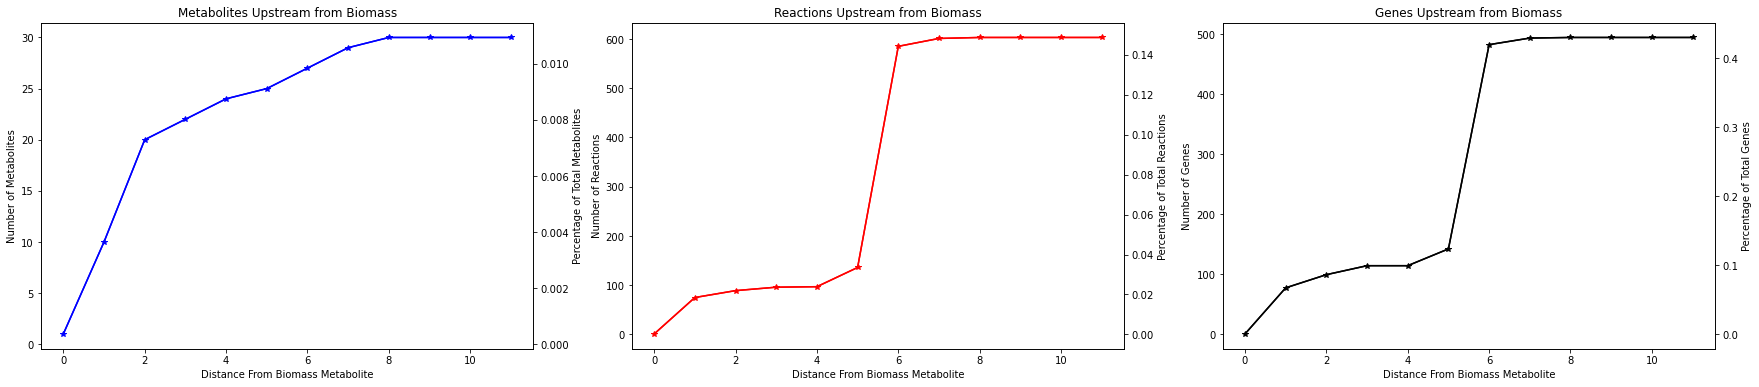

In [28]:
#plot the results, the count in on the left and the percentage is on the right
fig=plt.figure(figsize=(30,6))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)
#ax4=fig.add_subplot(224)

ax1p=ax1.twinx()
ax2p=ax2.twinx()
ax3p=ax3.twinx()

ax1.plot(count_dict['metab'],'b',label='Metabolite Count')
ax1p.plot(count_dict['metab']/len(fba_model.metabolites),'b*-',label='Metabolite Percent')

ax2.plot(count_dict['react'],'r',label='Reaction Count')
ax2p.plot(count_dict['react']/len(fba_model.reactions),'r*-',label='Reaction Percent')\

ax3.plot(count_dict['gene'],'k',label='Gene Count')
ax3p.plot(count_dict['gene']/len(fba_model.genes),'k*-',label='Gene Percent')


#fig.suptitle('Metabolites, Reactions, and Genes Upstream from Biomass\n With Respect to Distance in Stochiometric Network\n ')

ax1.set_title('Metabolites Upstream from Biomass')
ax1.set_xlabel('Distance From Biomass Metabolite')
ax1.set_ylabel('Number of Metabolites')
ax1p.set_ylabel('Percentage of Total Metabolites')

ax2.set_title('Reactions Upstream from Biomass')
ax2.set_xlabel('Distance From Biomass Metabolite')
ax2.set_ylabel('Number of Reactions')
ax2p.set_ylabel('Percentage of Total Reactions')

ax3.set_title('Genes Upstream from Biomass')
ax3.set_xlabel('Distance From Biomass Metabolite')
ax3.set_ylabel('Number of Genes')
ax3p.set_ylabel('Percentage of Total Genes')

fig.show()
plt.savefig('../kieran_collab_code/kyle_notebooks/reaction_percentages/output/biomass.png')

In [9]:
#I am now getting the list of secretable metabolites to put into the counting algorithm. 
#I copied this over from another code. 
e_metab_list=[]
for i in fba_model.metabolites:
    if 'e'==i.compartment:
        e_metab_list.append(i)

#get list of reactions which have compartments 
transport_list=[] #reactions with products (secrete/produce compounds in the extracellular space) and different compartment 
exchange_list=[] #exchange reactions in the extracellular space
for i in fba_model.reactions: #look at all reactions in the model
    if 'e' in i.compartments: #filter reactions that have at least one species in the extracellular space
        if i.compartments!={'e'}: #look at reactions which have more than one compartment

            #add each reaction with a secreted extracellular reactant. There must be a negative flux for the metabolite to be secreted
            for j in i.reactants: 
                if j.compartment=='e':
                    if i.lower_bound<0:
                        transport_list.append(i)

            #add each reaction with as secreted extracellular product. There must be a postive flux for the metabolite to be secreted
            for j in i.products:
                if j.compartment=='e':
                    if i.upper_bound>0:
                        transport_list.append(i)
        elif i in fba_model.exchanges:
            exchange_list.append(i)
                        
tranport_list=list(set(transport_list))  #remove duplicate reactions
exchange_list=list(set(exchange_list))  #remove duplicate reactions

#get list of unique metabolites in the product reactions 
transport_metabolite_list=[] #product metabolites list
for i in transport_list: #look at each product reactions
    for j in i.metabolites: #look at each metabolite in the reaction
        if j.compartment=='e': #filter the extracellar metabolites
            transport_metabolite_list.append(j) #add the extracelluar metabolites to the product metabolites list
transport_metabolite_list=list(set(transport_metabolite_list)) #remove duplicate metabolites

#get list of unique metabolites in the product reactions 
exchange_metabolite_list=[] #product metabolites list
for i in exchange_list: #look at each product reactions
    for j in i.metabolites: #look at each metabolite in the reaction
        if j.compartment=='e': #filter the extracellar metabolites
            exchange_metabolite_list.append(j) #add the extracelluar metabolites to the product metabolites list
exchange_metabolite_list=list(set(exchange_metabolite_list)) #remove duplicate metabolites


#Get dictionary of whether a extracelluar metabolite can potentially be secreted. 
name_list=[] #list of with form [[name,formula,molar mass, charge,secreted boolean]]
for i in e_metab_list:
    
    secreted_bool=0
    if i in transport_metabolite_list:
        secreted_bool=1
        
        
    #print(i.formula)
    name_list.append([i.id,secreted_bool])
    
#get the list of metabolites that are secretable    
df_secretable=pd.DataFrame(name_list,columns=['metabolite','secretable?'])
df_secretable=df_secretable.set_index('metabolite')
secretable_metabs=list(df_secretable['secretable?'][df_secretable['secretable?']>0].index)
print('There are %d secretable metabolites. This is a upper limit since most of these will not be secreted.' % len(secretable_metabs))

There are 218 secretable metabolites. This is a upper limit since most of these will not be secreted.


In [10]:
current_metabs=secretable_metabs
metab_dict={}
react_dict={}
metab_set=[]
react_set=[]
gene_set=[]
count_dict={'metab':[],'react':[],'gene':[]}
n_jumps=12
for i in range(n_jumps):
    metab_dict[i]=current_metabs
    metab_set=np.append(metab_set,metab_dict[i])
    react_dict[i]=[]
    for j,metab in enumerate(current_metabs): 
        reactions=S.loc[metab][S.loc[metab]!=0]
        reactions=reactions[reactions>0] #only keep the reactions with positive coeffs so we go upstream in the reactions
        react_dict[i]=list(np.append(react_dict[i],reactions.index))
        for k, react_index in enumerate(reactions.index):
            reactants=S[react_index][S[react_index]!=0]
            reactants=reactants[reactants<0] #the negative coefficients give the reactants in the reaction
            current_metabs=list(reactants.index)
    react_set=np.append(react_set,react_dict[i])
    
    metab_set=list(set(metab_set))
    count_dict['metab']=np.append(count_dict['metab'],len(metab_set))
    react_set=list(set(react_set))
    count_dict['react']=np.append(count_dict['react'],len(react_set))
    
    for react in react_set: 
        gene_set=list(set(np.append(gene_set,reaction_gene_dict[react])))
    count_dict['gene']=np.append(count_dict['gene'],len(gene_set))
    
    #print(len(metab_set),len(react_set))

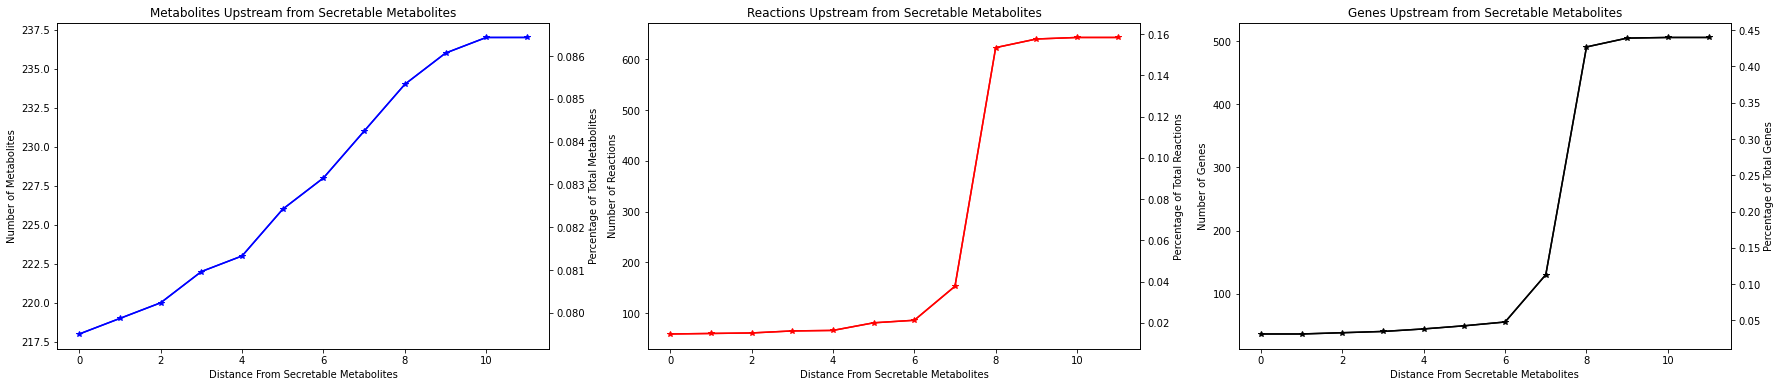

In [21]:
fig=plt.figure(figsize=(30,6))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)
#ax4=fig.add_subplot(224)

ax1p=ax1.twinx()
ax2p=ax2.twinx()
ax3p=ax3.twinx()

ax1.plot(count_dict['metab'],'b',label='Metabolite Count')
ax1p.plot(count_dict['metab']/len(fba_model.metabolites),'b*-',label='Metabolite Percent')

ax2.plot(count_dict['react'],'r',label='Reaction Count')
ax2p.plot(count_dict['react']/len(fba_model.reactions),'r*-',label='Reaction Percent')\

ax3.plot(count_dict['gene'],'k',label='Gene Count')
ax3p.plot(count_dict['gene']/len(fba_model.genes),'k*-',label='Gene Percent')


#fig.suptitle('Metabolites, Reactions, and Genes Upstream from Secretable Metabolites\n With Respect to Distance in Stochiometric Network')

ax1.set_title('Metabolites Upstream from Secretable Metabolites')
ax1.set_xlabel('Distance From Secretable Metabolites')
ax1.set_ylabel('Number of Metabolites')
ax1p.set_ylabel('Percentage of Total Metabolites')

ax2.set_title('Reactions Upstream from Secretable Metabolites')
ax2.set_xlabel('Distance From Secretable Metabolites')
ax2.set_ylabel('Number of Reactions')
ax2p.set_ylabel('Percentage of Total Reactions')

ax3.set_title('Genes Upstream from Secretable Metabolites')
ax3.set_xlabel('Distance From Secretable Metabolites')
ax3.set_ylabel('Number of Genes')
ax3p.set_ylabel('Percentage of Total Genes')

fig.show()
plt.savefig('../kieran_collab_code/kyle_notebooks/reaction_percentages/output/secretable_metabs.png')